In [1]:
import sys
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
import virtualTB
import random

env = gym.make('VirtualTB-v0')
env_action_space = env.action_space.shape[0]


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class OUNoise:

    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state * self.scale
    

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)

        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

nn.LayerNorm = LayerNorm


class Actor(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Actor, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

        self.mu = nn.Linear(hidden_size, num_outputs)
        self.mu.weight.data.mul_(0.1)
        self.mu.bias.data.mul_(0.1)

    def forward(self, inputs):
        x = inputs
        x = self.linear1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.ln2(x)
        x = F.relu(x)
        mu = torch.tanh(self.mu(x))
        return mu

class Critic(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Critic, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.linear2 = nn.Linear(hidden_size+num_outputs, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

        self.V = nn.Linear(hidden_size, 1)
        self.V.weight.data.mul_(0.1)
        self.V.bias.data.mul_(0.1)

    def forward(self, inputs, actions):
        x = inputs
        x = self.linear1(x)
        x = self.ln1(x)
        x = F.relu(x)
#         print(x.shape)
#         print(actions.shape)
        x = torch.cat((x, actions), 1)
        x = self.linear2(x)
        x = self.ln2(x)
        x = F.relu(x)
        V = self.V(x)
        return V

class DDPG(object):
    def __init__(self, gamma, tau, hidden_size, num_inputs, action_space, device):

        self.num_inputs = num_inputs
        self.action_space = action_space
        self.device = device

        self.actor = Actor(hidden_size, self.num_inputs, self.action_space).to(device)
        self.actor_target = Actor(hidden_size, self.num_inputs, self.action_space).to(device)
        self.actor_perturbed = Actor(hidden_size, self.num_inputs, self.action_space).to(device)
        self.actor_optim = Adam(self.actor.parameters(), lr=1e-5)

        self.critic = Critic(hidden_size, self.num_inputs, self.action_space).to(device)
        self.critic_target = Critic(hidden_size, self.num_inputs, self.action_space).to(device)
        self.critic_optim = Adam(self.critic.parameters(), lr=1e-4)

        self.gamma = gamma
        self.tau = tau
        self.update_counter = 0

        hard_update(self.actor_target, self.actor)  # Make sure target is with the same weight
        hard_update(self.critic_target, self.critic)


    def select_action(self, state, action_noise=None, param_noise=None):
        self.actor.eval()
        if param_noise is not None: 
            mu = self.actor_perturbed((Variable(state).to(device)))
        else:
            mu = self.actor((Variable(state).to(device)))

        self.actor.train()
        mu = mu.data

        if action_noise is not None:
            mu += torch.Tensor(action_noise.noise()).to(device)

        return mu.clamp(-1, 1)


    def update_parameters(self, batch):
        state_batch = Variable(torch.cat(batch.state)) #[128,91]
        action_batch = Variable(torch.cat(batch.action)) #[128,27]
        reward_batch = Variable(torch.cat(batch.reward)) #[128]
        mask_batch = Variable(torch.cat(batch.mask)) #[128]
        next_state_batch = Variable(torch.cat(batch.next_state)) #[128,91]
        
#         print('state_batch:', state_batch.shape)
#         print('action_batch:', action_batch.shape)
#         print('reward_batch:', reward_batch.shape)
#         print('mask_batch:', mask_batch.shape)
        
        next_action_batch = self.actor_target(next_state_batch) #[128,27]
#         print('next_a_batch1:', next_action_batch.shape)
        next_action_batch = next_action_batch.data
        next_action_batch += torch.Tensor(OUNoise(env_action_space).noise()).to(device)
        next_action_batch = next_action_batch.clamp(-1,1)
#         print('next_a_batch2:', next_action_batch.shape)
        
        
        next_state_action_values = self.critic_target(next_state_batch, next_action_batch)

        reward_batch = reward_batch.unsqueeze(1)
        mask_batch = mask_batch.unsqueeze(1)
        expected_state_action_batch = reward_batch + (self.gamma * mask_batch * next_state_action_values)

        self.critic_optim.zero_grad()

        state_action_batch = self.critic((state_batch), (action_batch))

        value_loss = F.mse_loss(state_action_batch, expected_state_action_batch)
        value_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()

        policy_loss = -self.critic((state_batch),self.actor((state_batch)))

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()
        
        self.update_counter += 1
        
        if self.update_counter == 100:    
            soft_update(self.actor_target, self.actor, self.tau)
            soft_update(self.critic_target, self.critic, self.tau)
            self.update_counter = 0

        return value_loss.item(), policy_loss.item()

    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            param += torch.randn(param.shape) * param_noise.current_stddev

    def save_model(self, env_name, suffix="", actor_path=None, critic_path=None):
        if not os.path.exists('models/'):
            os.makedirs('models/')

        if actor_path is None:
            actor_path = "models/ddpg_actor_{}_{}".format(env_name, suffix) 
        if critic_path is None:
            critic_path = "models/ddpg_critic_{}_{}".format(env_name, suffix) 
        print('Saving models to {} and {}'.format(actor_path, critic_path))
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

    def load_model(self, actor_path, critic_path):
        print('Loading models from {} and {}'.format(actor_path, critic_path))
        if actor_path is not None:
            self.actor.load_state_dict(torch.load(actor_path))
        if critic_path is not None: 
            self.critic.load_state_dict(torch.load(critic_path))
            
env.close()

In [3]:
import gym
import math
import torch
import random
import virtualTB
import time, sys
import configparser
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import wrappers
from copy import deepcopy
from collections import namedtuple
import pickle
import matplotlib
import matplotlib.pyplot as plt

FLOAT = torch.FloatTensor
LONG = torch.LongTensor
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

Transition = namedtuple(
    'Transition', ('state', 'action', 'mask', 'next_state', 'reward'))

env = gym.make('VirtualTB-v0')

env.seed(0)
np.random.seed(0)
torch.manual_seed(0)

agent = DDPG(gamma = 0.99, tau = 0.001, hidden_size = 128,
                    num_inputs = env.observation_space.shape[0], action_space = env.action_space, device=device)

memory = ReplayMemory(10000)

ounoise = OUNoise(env.action_space.shape[0])
param_noise = None

rewards = []
test_reward_record = []
ctr_record = []
reward_record = []
value_loss_record = []
policy_loss_record = []

total_numsteps = 0
updates = 0
test_ep = 100


for i_episode in range(100000):
    state = torch.Tensor([env.reset()])

    episode_reward = 0
    while True:
        action = agent.select_action(state, ounoise, param_noise) # [1,27]
#         print(action.shape)
#         print(type(action.cpu().numpy()[0]))
        next_state, reward, done, _ = env.step(action.cpu().numpy()[0])
#         print('next_state: ', next_state.shape)
#         print('reward: ', reward)
        total_numsteps += 1
        episode_reward += reward
        reward_record.append(reward)
        
        action = torch.Tensor(action.cpu()) # [1, 27]
        mask = torch.Tensor([not done]) # [1]
        next_state = torch.Tensor([next_state]) # [1, 91]
        reward = torch.Tensor([reward]) # [1]
#         print('action: ', action.shape)
#         print('next_state:', next_state.shape)
        
        memory.push(state.to(device), action.to(device), mask.to(device), next_state.to(device), reward.to(device))

        state = next_state
        
        # 可以加提前终止的机制
        
        if done:
            break
            
            
    if i_episode >= 30 and i_episode % 10 == 0:
        for _ in range(10):
            transitions = memory.sample(128)
            batch = Transition(*zip(*transitions))

            value_loss, policy_loss = agent.update_parameters(batch)
            value_loss_record.append(value_loss)
            policy_loss_record.append(policy_loss)

            updates += 1
            

    rewards.append(episode_reward)
    
    
    if i_episode % test_ep == 0:
        episode_reward = 0
        episode_step = 0
        for i in range(50):
            state = torch.Tensor([env.reset()])
            while True:
                action = agent.select_action(state)

                next_state, reward, done, info = env.step(action.cpu().numpy()[0])
                episode_reward += reward
                episode_step += 1

                next_state = torch.Tensor([next_state])

                state = next_state
                if done:
                    break

        # rewards.append(episode_reward)
        test_reward_record.append(episode_reward / 50)
        ctr_record.append(episode_reward / episode_step/ 10)
        print("Episode: {}, total numsteps: {}, average reward: {}, CTR: {}".format(i_episode, episode_step, episode_reward / 50, episode_reward / episode_step/ 10))
    
env.close()

Episode: 0, total numsteps: 619, average reward: 4.18, CTR: 0.03376413570274637
Episode: 100, total numsteps: 646, average reward: 5.74, CTR: 0.04442724458204335
Episode: 200, total numsteps: 711, average reward: 14.56, CTR: 0.10239099859353025
Episode: 300, total numsteps: 857, average reward: 25.32, CTR: 0.14772462077012835
Episode: 400, total numsteps: 777, average reward: 10.86, CTR: 0.06988416988416989
Episode: 500, total numsteps: 676, average reward: 19.16, CTR: 0.14171597633136096
Episode: 600, total numsteps: 595, average reward: 18.28, CTR: 0.15361344537815128
Episode: 700, total numsteps: 758, average reward: 23.2, CTR: 0.15303430079155672
Episode: 800, total numsteps: 1038, average reward: 54.88, CTR: 0.26435452793834296
Episode: 900, total numsteps: 639, average reward: 20.78, CTR: 0.1625978090766823
Episode: 1000, total numsteps: 744, average reward: 24.58, CTR: 0.16518817204301076
Episode: 1100, total numsteps: 721, average reward: 25.02, CTR: 0.17350901525658807
Episode

Episode: 11100, total numsteps: 691, average reward: 124.38, CTR: 0.9
Episode: 11200, total numsteps: 637, average reward: 114.66, CTR: 0.9
Episode: 11300, total numsteps: 640, average reward: 115.2, CTR: 0.9
Episode: 11400, total numsteps: 572, average reward: 102.96, CTR: 0.9
Episode: 11500, total numsteps: 626, average reward: 112.68, CTR: 0.9
Episode: 11600, total numsteps: 546, average reward: 98.28, CTR: 0.9
Episode: 11700, total numsteps: 952, average reward: 171.36, CTR: 0.9
Episode: 11800, total numsteps: 773, average reward: 139.14, CTR: 0.9
Episode: 11900, total numsteps: 649, average reward: 116.82, CTR: 0.9
Episode: 12000, total numsteps: 688, average reward: 123.84, CTR: 0.9
Episode: 12100, total numsteps: 475, average reward: 85.5, CTR: 0.9
Episode: 12200, total numsteps: 568, average reward: 102.24, CTR: 0.9
Episode: 12300, total numsteps: 750, average reward: 135.0, CTR: 0.9
Episode: 12400, total numsteps: 549, average reward: 98.82, CTR: 0.9
Episode: 12500, total nums

KeyboardInterrupt: 

In [5]:
torch.save(agent,'ddpg.pt')
# model = torch.load('ddpg.pt')

In [4]:
with open('./rewards_record.pkl', 'wb') as f:
    pickle.dump(rewards, f)
with open('./test_reward_record.pkl', 'wb') as f:
    pickle.dump(test_reward_record, f)
with open('./ctr_record.pkl', 'wb') as f:
    pickle.dump(ctr_record, f)
with open('./reward_record.pkl', 'wb') as f:
    pickle.dump(reward_record, f)
with open('./value_loss_record.pkl', 'wb') as f:
    pickle.dump(value_loss_record, f)
with open('./policy_loss.pkl', 'wb') as f:
    pickle.dump(policy_loss_record, f)    

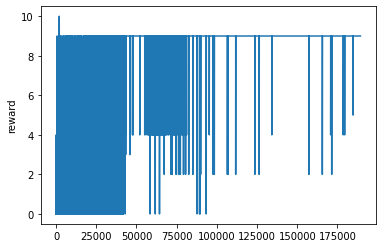

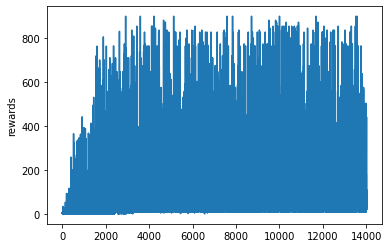

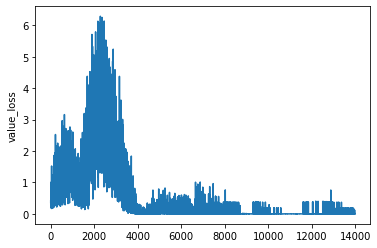

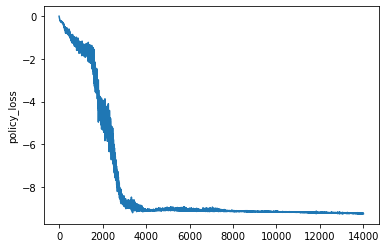

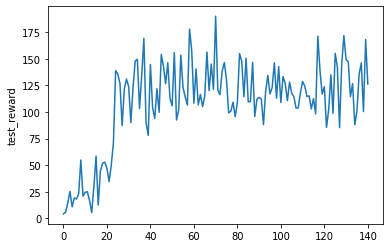

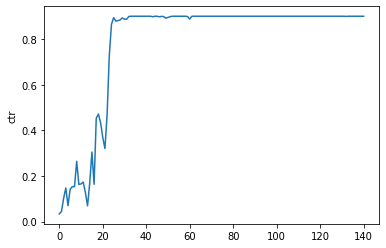

In [5]:
def getInfo():
    '''返回六个列表,分别用于保存reward/rewards/value_loss/policy_loss/test_reward/ctr'''
    info = list()
    fileNames = [
        './reward_record.pkl',
        './rewards_record.pkl',
        './value_loss_record.pkl',
        './policy_loss.pkl',
        './test_reward_record.pkl',
        './ctr_record.pkl']  # 文件的名字
    for name in fileNames:
        with open(name, 'rb') as f:
            item = pickle.load(f)
            info.append(item)
    return info

reward_record, rewards, value_loss_record, policy_loss_record, test_reward_record,ctr_record = getInfo()

plt.plot(reward_record)
plt.ylabel('reward')
plt.show()

plt.plot(rewards)
plt.ylabel('rewards')
plt.show()

plt.plot(value_loss_record)
plt.ylabel('value_loss')
plt.show()

plt.plot(policy_loss_record)
plt.ylabel('policy_loss')
plt.show()

plt.plot(test_reward_record)
plt.ylabel('test_reward')
plt.show()

plt.plot(ctr_record)
plt.ylabel('ctr')
plt.show()